**<p style='text-align: right;'>Ver. 1.0.3</p>**

#### IMPORTS
Execute the cell below to import all packages needed.  If you are not using Noteable, make sure the python and package version numbers reported match the python and package numbers, which can be checked by running the following cell. The Python version does not need to be the same, but it should be $3.9.p$, where $p \ge 12$.

In [1]:
import pandas as pd
import numpy as np
import scipy
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.cluster import KMeans

from iaml23cw_helpers import *
print_versions();

# You may add other libraries here or in your other cells as needed.



Python	3.9.12 : Ok
Scipy	1.7.3 : Ok
Numpy	1.21.6 : Ok
Sklearn	1.1.1 : Ok
Pandas	1.4.2 : Ok
Matplotlib	3.5.2 : Ok
Seaborn	0.11.2 : Ok


\pagebreak

# Experiments with image data

#### 65 marks out of 130 for this coursework

Image data are made up of $H × W × C$ pixels, where $H, W, C$ denote the height, width, and the number of channels, respectively. For simplicity, we assume a grayscale image (i.e. $C=1$). Let $p_{ij}$ denote the pixel value at a grid point $(i,j), 1 \le i \le H, 1 \le j \le W$, where $p_{11}$ corresponds to the the pixel at the top-left corner and $p_{HW}$ to the one at the bottom-right corner. We assume that $p_{ij}$ takes an integer value between 0 and 255 (i.e. 8-bit coding). In computers, we can store a grayscale image of $\{p_{ij}\}$ in a $D$-dimensional vector, $x = (x_1,x_2,...,x_D)$, where $D = H \times W$, and $x_1$ corresponds to $p_{11}$ and $x_D$ to $p_{HW}$.

In this question, we use a subset of the [Fashion MNIST Dataset](https://github.com/zalandoresearch/fashion-mnist), which contains images of fashion products from ten categories (e.g. T-shirt and trousers). The ten categories are represented as integer numbers ($0,\ldots,9$) and they are referred to as classes. There are 1000 training instances and 200 test instances per class. Each instance is a 28-by-28 grayscale image. Note that you will find some errors (e.g. incorrect labels) in the data set, but we use the data set as it is.
Load the data and apply some pre-processing in the following manner in your code.

***Loading data:***
Make sure that you have the data set file "dset_q2.mat" in your environment and run the following cell to load the data set.

In [28]:
# Load the data set and apply some preprocessing

Xtrn_org, Ytrn_org, Xtst_org, Ytst_org = load_q2_dataset()

Xtrn = np.copy(Xtrn_org) / 255.0   # Training data : (10000, 784)
Xtst = np.copy(Xtst_org) / 255.0   # Testing data : (2000, 784)
Ytrn = np.copy(Ytrn_org)           # Labels for Xtrn : (10000,)
Ytst = np.copy(Ytst_org)           # Labels for Xtst : (2000,)
Xmean = np.mean(Xtrn, axis=0)
Xtrn_mn = Xtrn - Xmean; Xtst_mn = Xtst - Xmean  # Mean-normalised versions of data

You can display the image of the fourth instance in **Xtrn** in the following manner, for example. Run the following cell.

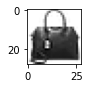

In [29]:
plt.figure(figsize=(1.0,1.0)) # You could try a much large fig size
plt.imshow(Xtrn[3,:].reshape(28,28), cmap=plt.cm.gray_r);
# plt.grid(lw=1, ls=':')
# plt.axis('off')


# ========== 1.1 ==========
[Code] For each class, display the grayscale images of the first five instances of the class in the training set **(Xtrn,Ytrn)**, where you should follow the specifications shown below.
- You will display a total of 50 images, which should be displayed in a 10-by-5 grid,  where a grid point $(i,j), i=0,\ldots,9, j=0,\ldots,4$,  displays the image of $j$-th instance of class $i$.  Note that we use zero-based numbering here.
- Use plt.imshow to display an image.
- Specify the figure size by plt.figure(figsize=(10, 20)).
- The image of each instance should be displayed properly in the right orientation.
- For each image, you should display the class number and the instance number in **Xtrn**, for which you could use **pyplot.title**. For example, if the first instance of class 0 is held in **Xtrn[21,:]**, the instance number is 21, so that "C0: 21" (or "0: 21") may be the information you should display.

\pagebreak
## Codes for 1.1

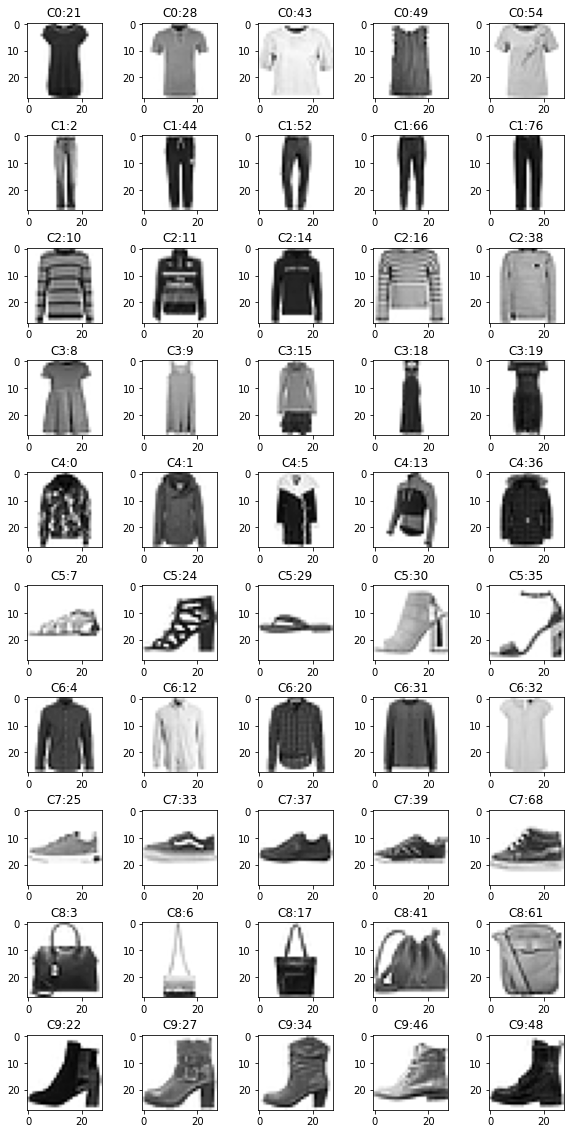

In [30]:
# Your code goes here
fig = plt.figure(figsize=(10,20))
#fig, axes = plt.subplots(10,5, figsize=(10,20))

count = 0
counts_category = [0,0,0,0,0,0,0,0,0,0]
for i,val in enumerate(Ytrn):
    if (count >= 50):
        break
    else:
        exist = counts_category[val]
        if (exist >= 5):
            continue
        else:
            ax = fig.add_subplot(10,5,val*5+exist+1)
            ax.imshow(Xtrn[i,:].reshape(28,28), cmap=plt.cm.gray_r)
            ax.set_title('C{}:{}'.format(val,i))
            counts_category[val] = counts_category[val] + 1
            count = count + 1
    #plt.subplot()
    #plt.imshow()
plt.subplots_adjust(hspace=0.5)
plt.show()

\pagebreak

# ========== 1.2 ==========

You may have understood there is a wide variety of images in each class. We now would like to display the images of representative instances for each class in the training data set **(Xtrn, Ytrn)**. To that end, we apply the k-means clustering with $k = 6$ to each class. Instead of displaying the image of each cluster centre, which would look blurred due to averaging, we display the image of the instance that is closest to the centroid (i.e. cluster centre) as the representative of the cluster. We also display the mean image (i.e. the image of the mean vector) of each class.

[Code] Following the specifications shown below, display the result.
- For clustering, use sklearn's **KMeans** with the default parameters except that you specify **n_clusters=6** and **random_state=0**. Note that the two parameters should be specified explicitly when you run clustering for each class.
- You will display a total of 60+10=70 images, which should be displayed in a 10-by-7 grid. Each row corresponds to a class. The grid point $(i, 0)$ displays the mean image of class $i$ data, and the grid point $(i, j), j=1,\ldots,6$  displays the image of the representative of cluster $j$-1 for class $i$. Clusters should be sorted in increasing order in terms of the Euclidean distance to the centre of the class (i.e. the mean of the instances in the class), so that the column $j$=1 corresponds to the cluster that is closest to the class centre, whereas column $j$=6 to the one that is farthest from the class centre. Note that we use zero-based numbering.
- For each image of an instance, display the class number ($c$), the number of instances ($m$) in the cluster, and the instance number ($\ell$) in the training data set, in the format of "C{$c$} [{$m$}] {$\ell$}". For example, "C2 [165] 9734" represents $c$=2. $m$=165, and $\ell$=9734.
- Use a large figure size for plotting, e.g. plt.figure(figsize=(16,20)).

\pagebreak
## Codes for 1.2

In [31]:
# Your code goes here

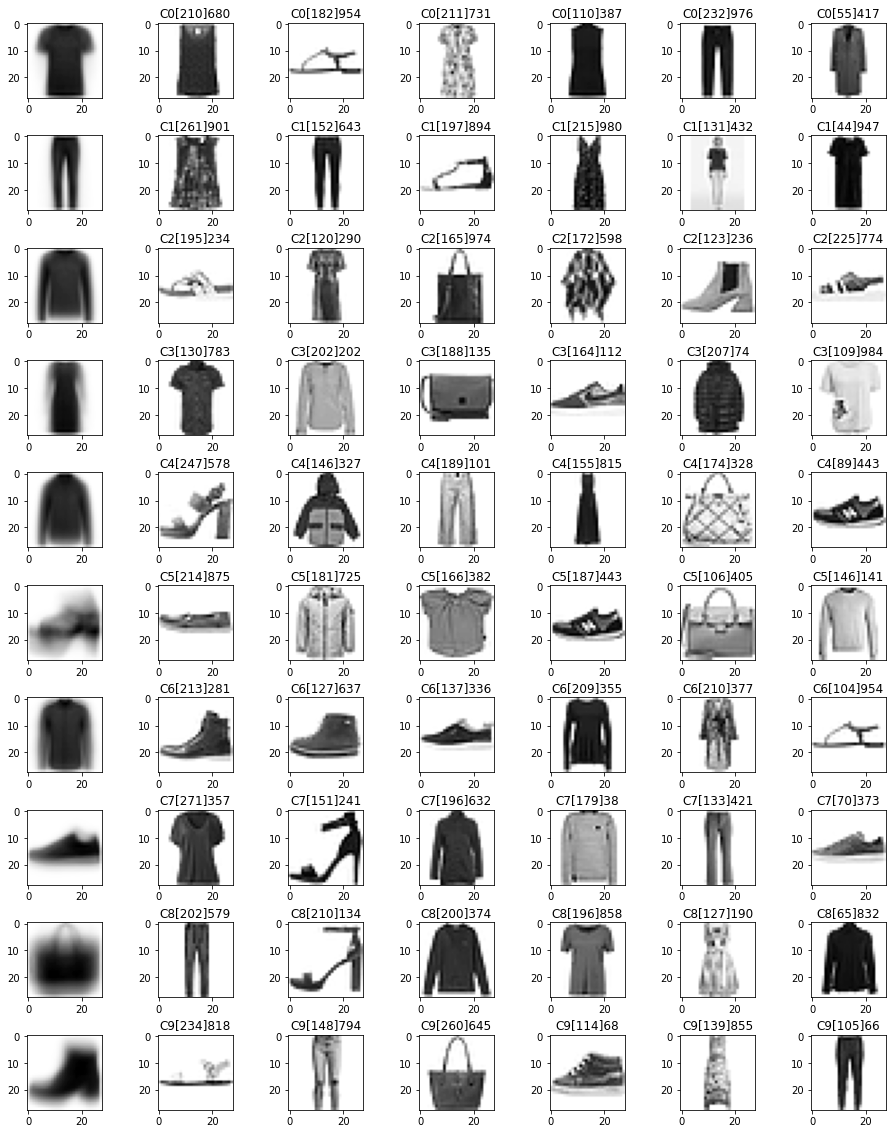

In [32]:
fig = plt.figure(figsize=(16,20))

# 分成10类
subsets = [[],[],[],[],[],[],[],[],[],[]]
for i,val in enumerate(Ytrn):
    subsets[val].append(Xtrn[i])

for i in range(10):
    sub_group = np.array(subsets[i])
    length = len(sub_group)
    sum_ = [0 for _ in range(784)]
    for j,val in enumerate(sub_group):
        sum_ = sum_ + val
    mean_vector = sum_/length
    ax = fig.add_subplot(10,7,i*7+1)
    ax.imshow(mean_vector.reshape(28,28), cmap=plt.cm.gray_r)

    kmeans = KMeans(n_clusters=6, random_state=0)
    ft = kmeans.fit_transform(sub_group)
    # 对聚类按centroid排序
    center_distance = pd.DataFrame(columns=['distance'])
    
    sums = [0,0,0,0,0,0]
    for val in kmeans.labels_:
        sums[val] = sums[val] + 1
        
    centers = kmeans.cluster_centers_
    for j,val in enumerate(centers):
        substraction = mean_vector - val
        distance = math.sqrt(np.sum(substraction**2))
        center_distance.loc[j] = [distance]
        
    center_distance.sort_values(by='distance', inplace = True)
        
    #找到距离centroid最近的实例
    distance_to_centroids = pd.DataFrame(columns=['index_','cluster0','cluster1','cluster2','cluster3','cluster4','cluster5'])
    for k,dis in enumerate(ft):
        instance_dis = dis
        distance_to_centroids.loc[k] = [k, dis[0], dis[1], dis[2], dis[3], dis[4], dis[5]]

    count = 0
    for index,row in center_distance.iterrows():
            
        sorted_ = distance_to_centroids.sort_values(by='cluster{}'.format(index))
        c_index = int(sorted_.iat[0,0])
        ax = fig.add_subplot(10,7,i*7+count+2)
        ax.set_title('C{}[{}]{}'.format(i,sums[index],c_index))
        ax.imshow(Xtrn[c_index,:].reshape(28,28), cmap=plt.cm.gray_r)
        count = count + 1
    
#print(kmeans.inertia_, kmeans.labels_, kmeans.cluster_centers_)

plt.subplots_adjust(hspace=0.5)
plt.show()


\pagebreak

# ========== 1.3 ==========
1. [Code] Apply Principal Component Analysis (PCA) to the data of **Xtrn_mn** using sklearn's **PCA** and show the variances of projected data for the first five principal components. 
2. [Code] Plot a graph of the cumulative explained variance ratio $r_i$ as a function of the number of principal components, $i$, where $ 1 \le i ≤ D$, $r_i$ is defined as follows, and $D$ is the number of dimensions of the data.<br>
> $$ r_i = \frac{\sum_{j=1}^i \lambda_j}{\sum_{j=1}^D \lambda_j}$$
3. [Code] Find the minimum number of principal components required to explain 50%, 60%, 70%, 80%, 90%, and 95% of the total variance, respectively.


\pagebreak
## Codes for 1.3

In [33]:
#(1) Your code goes here
pca2 = PCA(n_components=5)
pca2.fit(Xtrn_mn)
print(pca2.explained_variance_)
print(pca2.explained_variance_ratio_)

[19.88435226 12.063576    4.12262269  3.38829987  2.64814917]
[0.29177223 0.17701439 0.06049313 0.04971808 0.03885751]


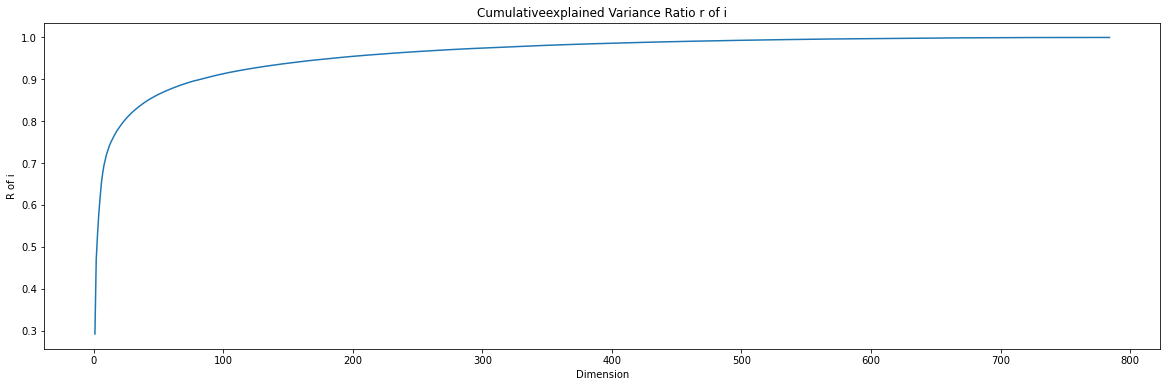

In [42]:
#(2) Your code goes here
d = Xtrn_mn.shape[1]
cummulation = pd.DataFrame(columns=['Num of PC', 'sum variance'])
for i in range(1,d+1):
    pca_ = PCA(n_components=i)
    pca_.fit(Xtrn_mn)
    sum_ = sum(pca_.explained_variance_ratio_)
    cummulation.loc[i-1] = [i, sum_]
# print(cummulation)
denominator = cummulation.iat[d-1,1]

cummulation['r'] = cummulation['sum variance']/denominator

plt.figure(figsize=(20,6))
plt.title('Cumulativeexplained Variance Ratio r of i')
plt.plot(cummulation['Num of PC'], cummulation['r'])
plt.xlabel('Dimension')
plt.ylabel('R of i')

plt.show()

In [37]:
#(3) Your code goes here
min_1 = cummulation[cummulation['r'] >=0.5]
print('minimum number of principal components to explain 50% of total variance: {}'.format(int(min_1.iat[0,0])))

min_2 = cummulation[cummulation['r'] >=0.6]
print('minimum number of principal components to explain 60% of total variance: {}'.format(int(min_2.iat[0,0])))

min_3 = cummulation[cummulation['r'] >=0.7]
print('minimum number of principal components to explain 70% of total variance: {}'.format(int(min_3.iat[0,0])))

min_4 = cummulation[cummulation['r'] >=0.8]
print('minimum number of principal components to explain 80% of total variance: {}'.format(int(min_4.iat[0,0])))

min_5 = cummulation[cummulation['r'] >=0.9]
print('minimum number of principal components to explain 90% of total variance: {}'.format(int(min_5.iat[0,0])))

min_6 = cummulation[cummulation['r'] >=0.95]
print('minimum number of principal components to explain 95% of total variance: {}'.format(int(min_6.iat[0,0])))


minimum number of principal components to explain 50% of total variance: 3
minimum number of principal components to explain 60% of total variance: 5
minimum number of principal components to explain 70% of total variance: 9
minimum number of principal components to explain 80% of total variance: 24
minimum number of principal components to explain 90% of total variance: 83
minimum number of principal components to explain 95% of total variance: 183


\pagebreak

# ========== 1.4 ==========
We now consider a simple application of PCA, in which we (as sender A) apply dimensionality reduction to image samples and send them to someone (as receiver B) who tries to reconstruct the samples from the dimensionality-reduced samples. The underlying assumption is that the both parties, A and B, share the same set of principal components (i.e. eigen vectors) and the mean vector (**Xmean**) in advance.
You will expect some degradation in the reconstructed images.
1. [Code] Follow the instructions shown below.
- Apply PCA to the whole **Xtrn_mn** at first to find all principal components. 
- For each class and for each number of principal components $K = 5,20,50,200,400$, apply the dimensionality reduction to the first instance in the class.
- Display the reconstructed images and the original images in a 10-by-6 grid, where each row corresponds to a class (in increasing order) and the first five columns show the reconstructed images for the five values of $K$ (in increasing order) and the last column to shows the original image.
- Note that you should add **Xmean** to each reconstructed data to display the corresponding image.
2. [Text] Explain your findings briefly.

\pagebreak
## Codes for 1.4

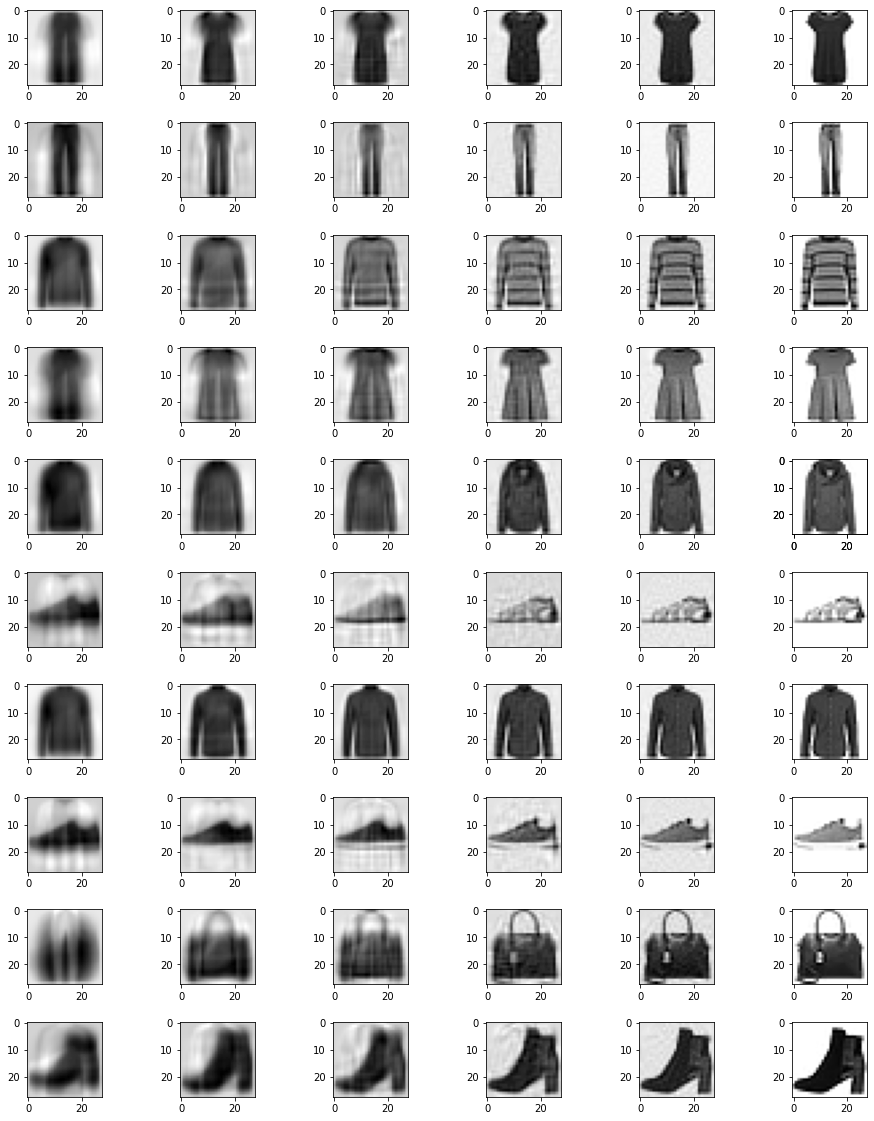

In [38]:
#(1) Your code goes here
fig = plt.figure(figsize=(16,20))

indexes = [0,0,0,0,0,0,0,0,0,0]
# original image
for i,val in enumerate(Ytrn):
    if (indexes[val] == 0):
        ax = fig.add_subplot(10,6,(val+1)*6)
        ax.imshow(Xtrn[i,:].reshape(28,28), cmap=plt.cm.gray_r)
        indexes[val] = i

for j,k in enumerate([5,20,50,200,400]):
    pca_ = PCA(n_components=k)
    reconstructed = pca_.fit_transform(Xtrn_mn)
    original_ = pca_.inverse_transform(reconstructed)
    for_pic = original_ + Xmean;
    for m,index in enumerate(indexes):
        ax = fig.add_subplot(10,6,m*6+1+j)
        ax.imshow(for_pic[index,:].reshape(28,28), cmap=plt.cm.gray_r)
    
plt.subplots_adjust(hspace=0.5)
plt.show() 

#(2) ***Your text goes here***

Based on PCA, we can realize the recovery of pictures to some extent. The larger number of principal components K we set,the loss of original image is lower. When we set K=400, which is about half of the original dimensions, we can largely preserve the image clarity. So using PCA to compress image and recover is feasible and effective.  
However, we can not meet the requirements of very small loss of image and very small transmission volume of data at the same time.

\pagebreak

# ========== 1.5 ==========

We now would like to know how the training data **Xtrn_mn** distribute in a vector space. To visualise distributions, we reduce the dimensionality of the data to two dimensions using PCA and plot the dimensionality-reduced data on the two-dimensional plane spanned by the first principal components. Note that each instance in the data set is now displayed as a single point on the plane.
1. [Code] Plot all the training instances (**Xtrn_mn**) on the two-dimensional PCA plane, where each instance is displayed as a small point with a colour specific to the class of the instance. Use the ’tab10’ colormap for plotting (i.e. cmap="tabl10"), and adjust the marker size so that points do not overlap each other very much.
2. [Text] Give comments on the separation of the classes, and explain your findings briefly.


\pagebreak
## Codes for 1.5

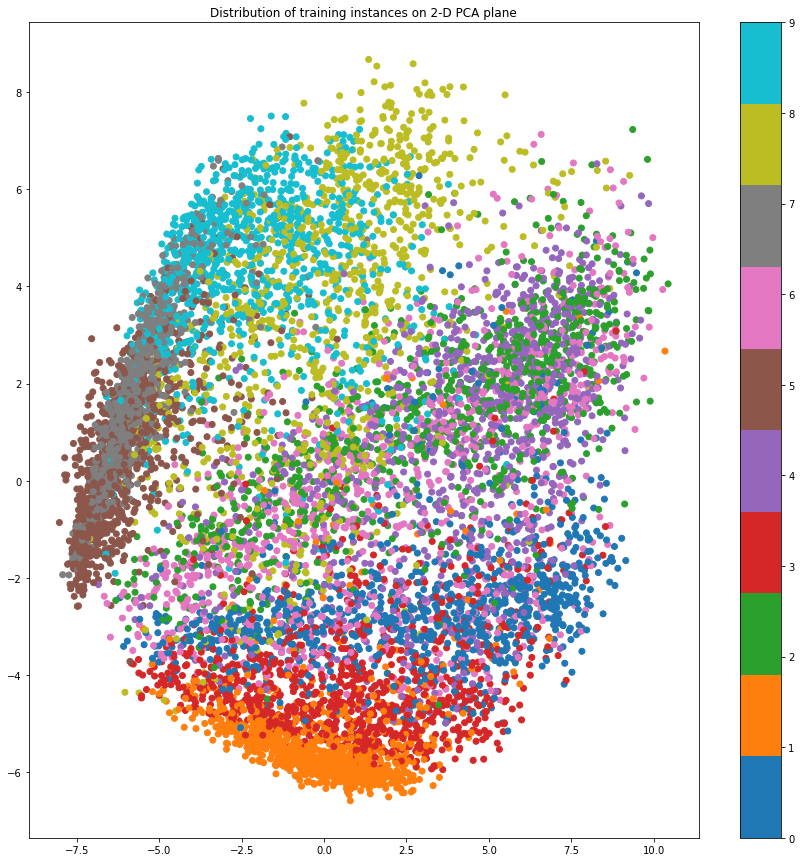

In [39]:
#(1) Your code goes here
pca_2d = PCA(n_components=2)
reconstructed = pca_2d.fit_transform(Xtrn_mn)

x,y,color = [],[],[]
for i,val in enumerate(Ytrn):
    color.append(val)
    x.append(reconstructed[i][0])
    y.append(reconstructed[i][1])

fig = plt.figure(figsize=(15,15))
plt.title('Distribution of training instances on 2-D PCA plane')
plt.scatter(x, y, c=color, cmap='tab10')
plt.colorbar()
plt.show()  

#(2) ***Your text goes here***

Some classes have the feature of gathering together on the 2-D plane such as orange dots labelled '1' and grey dots labelld '5', but some classes are discrete.  
And overall, instances from different classes are mixed and there is no obvious pattern, so it's not wise to reduce the dimensionality if we want to distinguish these classes from each other.

\pagebreak

# ========== 1.6 ==========

We consider applying multiclass classification to the data set. Make sure that you use **Xtrn_mn** for training and **Xtst_mn** for testing. 
1. [Code] Carry out a classification experiment using sklearn's **LogisticRegression** with "random_state=0", and report the classification accuracy and confusion matrix for the training set and test set respectively. Use sklearn's **ConfusionMatrixDisplay** to display the confusion matrix. Note that you may ignore a warning message in the training.
2. [Code] Run a classification experiment with SVM and report the classification accuracy and confusion matrix for the training set and test set respectively. Use sklearn's **SVC** with "random_state=0".
3. [Text] Based on the results obtained in 1 and 2, explain your findings and give brief discussions.

\pagebreak
## Codes for 1.6

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Accuracy for test set: 0.9237
Classification Accuracy for test set: 0.819


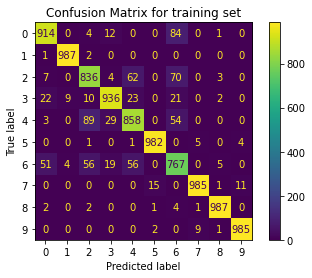

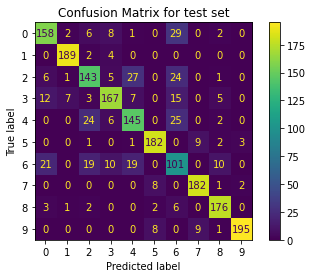

In [40]:
#(1) Your code goes here
lr_pic = LogisticRegression(random_state=0).fit(Xtrn_mn, Ytrn)

accuracy0 = lr_pic.score(Xtrn_mn,Ytrn)
print('Classification Accuracy for test set: {}'.format(accuracy0))

accuracy1 = lr_pic.score(Xtst_mn,Ytst)
print('Classification Accuracy for test set: {}'.format(accuracy1))

y_train_pred = lr_pic.predict(Xtrn_mn)
y_test_pred = lr_pic.predict(Xtst_mn)

#fig = plt.figure(figsize=(15,15))
#ax = fig.add_subplot(1,2,1)

cm1 = ConfusionMatrixDisplay.from_predictions(y_train_pred, Ytrn)
cm1.ax_.set_title('Confusion Matrix for training set')
#cm1.plot()

cm2 = ConfusionMatrixDisplay.from_predictions(y_test_pred, Ytst)
cm2.ax_.set_title('Confusion Matrix for test set')
#cm2.plot()
plt.show()

Classification Accuracy for test set: 0.9145
Classification Accuracy for test set: 0.855


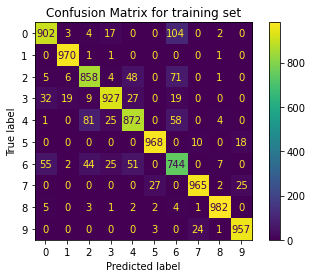

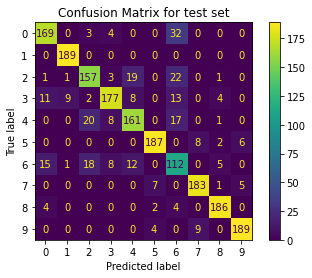

In [41]:
#(2) Your code goes here
svm_pic = SVC(random_state=0).fit(Xtrn_mn, Ytrn)

accuracy0_ = svm_pic.score(Xtrn_mn,Ytrn)
print('Classification Accuracy for test set: {}'.format(accuracy0_))

accuracy1_ = svm_pic.score(Xtst_mn,Ytst)
print('Classification Accuracy for test set: {}'.format(accuracy1_))

y_train_pred_ = svm_pic.predict(Xtrn_mn)
y_test_pred_ = svm_pic.predict(Xtst_mn)

cm1_ = ConfusionMatrixDisplay.from_predictions(y_train_pred_, Ytrn)
cm1_.ax_.set_title('Confusion Matrix for training set')

cm2_ = ConfusionMatrixDisplay.from_predictions(y_test_pred_, Ytst)
cm2_.ax_.set_title('Confusion Matrix for test set')

plt.show()

#(3) Your text goes here

Both models have higher accuracy on training set, which means both of them with existing params may be a little bit overfitting.  
Observing the confusion matrixes of both models, we can easily find that both of them have very high accuracy, because the color of squares lies on the diagonal from top left to bottom right is light and others are very dark. And we can also find that the the confusion matrixes of logistic regression have more light purple squares, which means SVM may be better to classify the dataset.

\pagebreak

# ========== 1.7 ==========

This is a mini project, in which you are asked to improve the classification accuracy for the logistic regression model as much as possible from the one obtained in Question 2.6. 
1. [Text] Discuss possible approaches, and decide the one(s) you implement. Note that you should stick to the multinomial logistic regression model and should not use other classification models.
2. [Code and Text] Implement the approach you have chosen, carry out a classification experiment and report accuracy for the training set and test set respectively. Note that training and parameter tuning should be done on the training set and not on the test set. In case that you run parameter tuning, show and explain the result clearly.
3. [Text] Making a quick investigation to the result, report your findings and give brief discussions.

\pagebreak
## Codes for 1.7

#(1) Your text goes here

In [ ]:
#(2) Your code and text goes here

#(3) Your text goes here